# Part II - Model testing #

In [1]:
#load model with RAdam optimizer:
# model = load_model(os.path.join(model_folder, 'model_effnB3_panda_check.20.h5'),\
#                    custom_objects={'RAdam': RAdam})

In [25]:
import os, shutil, gc, subprocess, sys, json, time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import skimage.io

#PIL.Image.MAX_IMAGE_PIXELS = 400000000
PIL.Image.MAX_IMAGE_PIXELS = None

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json, load_model
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow_addons.metrics import  CohenKappa
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import CustomObjectScope, get_custom_objects
from efficientnet import model
import functools
import keras

%env TF_KERAS = 1
from keras_radam import RAdam

env: TF_KERAS=1


In [4]:
import efficientnet as efn
print('efficientnet: {}'.format(efn.__version__))
import tensorflow as tf
print('tensorflow: {}'.format(tf.__version__))


efficientnet: 1.1.0
tensorflow: 2.2.0


In [5]:
from panda_bvv_config import *

### 1. Input data ###

In [6]:
Zoom = 2
pred_fold = 'testdata320'
model_folder = 'effnB3'
pred_file = 'ground320simple.npz'

# # wrapping for inputs:
pred_fold = os.path.join(base_path, pred_fold)
model_folder = os.path.join(model_path, model_folder)


In [7]:
model_folder

'/run/media/admin/kagg/panda/models/effnB3'

### 2. Standard functions ###

In [8]:
def inject_keras_modules(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = keras.backend
        kwargs['layers'] = keras.layers
        kwargs['models'] = keras.models
        kwargs['utils'] = keras.utils
        return func(*args, **kwargs)
    return wrapper

In [9]:
def init_keras_custom_objects():
    custom_objects = {
        'FixedDropout': inject_keras_modules(model.get_dropout)()
                    }
    get_custom_objects().update(custom_objects)
    

In [8]:
def prepare_df_data(test_df = test_cnn_labels,
                    data_fold = pred_fold):
    test_data = []
    test_labels = []
    df_f = []
    for i,row in enumerate(test_df.iterrows()): 
        img_num = row[1]['image_id']
        biopsy = skimage.io.imread(os.path.join(data_fold, 'testf',img_num + '.png'))
        test_data.append(biopsy)
        test_labels.append(row[1]['isup_grade'])
        df_f.append(img_num)
                           
    return np.array(test_data), np.array(test_labels)

In [38]:
test_data = np.load(os.path.join('/run/media/admin/kagg/panda/models/effnB3/test_data.npy'))
test_for_gen =  np.load(os.path.join('/run/media/admin/kagg/panda/models/effnB3', pred_file))['test_data']                   
test_labels = np.load(os.path.join('/run/media/admin/kagg/panda/models/effnB3', pred_file))['test_labels']
test_datagen = ImageDataGenerator(rescale = 1/255)


In [42]:
df_generator = test_datagen.flow(
                                x=test_for_gen,
                                y=None, 
                                batch_size=1,
                                shuffle = False,
                               )
steps = len(test_labels)

In [24]:
test_datagen = ImageDataGenerator(rescale = 1/255)
gs_generator = test_datagen.flow_from_directory(
        os.path.join(base_path, 'gs_proc_inv'),
        target_size=(320, 320),
        color_mode="rgb",
        batch_size= 1216,
        shuffle=False,
        class_mode='categorical')

Found 1294 images belonging to 4 classes.


In [11]:
test_labels[:10]

array([0, 3, 3, 0, 3, 4, 2, 5, 2, 3])

#### quick exploration of test data ####

In [27]:
#test_labels[:10]

In [12]:
sum(sum(test_data[1]))

array([184,  40, 164], dtype=uint8)

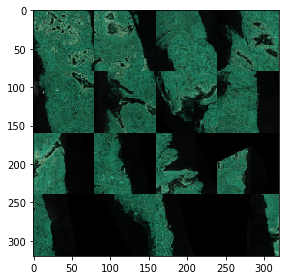

In [13]:
skimage.io.imshow(test_data[1])

#### accuracy and confusion matrix ####

In [12]:
if model_folder[35:39]  == 'effn':
    init_keras_custom_objects()
    print("Ready to load EfficientNet{} \n".format(model_folder[39:41]))

Ready to load EfficientNetB3 



In [13]:
init_keras_custom_objects()

### GS model ###

In [65]:
gs_model_folder = '/run/media/admin/kagg/panda/models/final_models/multi2'
gs_model_files = ['model_effnB3_panda_check.10.h5', 'model_effnB3_panda_check.18.h5']


In [66]:
gs_predict_raw = []
gs_predict_idx = []
for modelname_ in gs_model_files:
    model_ = load_model(os.path.join(gs_model_folder,modelname_))
    predictions = model_.predict(test_data)
    gs_predict_raw.append(predictions)


In [67]:
predict = gs_predict_raw[0]
train, val = train_test_split(predict, 
                              test_size= 0.2,
                              random_state=3010)

In [68]:
train_y, val_y = train_test_split(test_labels, 
                              test_size= 0.2,
                              random_state=3010)

In [ ]:
clf = LogisticRegression(random_state=0).fit(train, train_y)

In [72]:
gs_pred = clf.predict(gs_predict_raw[1])


In [73]:
np.corrcoef(test_labels, gs_pred)

array([[1.        , 0.51757841],
       [0.51757841, 1.        ]])

In [74]:
accuracy_score(test_labels, gs_pred)

0.4120065789473684

In [78]:
np.corrcoef(predIdxs_isup1[0], gs_pred)

array([[1.        , 0.55454856],
       [0.55454856, 1.        ]])

In [79]:
temp = gs_predict_raw[1][:5]

In [80]:
temp

array([[0.54306614, 0.006161  , 0.73575246, 0.00581041],
       [0.10984996, 0.07641652, 0.43433553, 0.0422979 ],
       [0.10093531, 0.00390181, 0.83178246, 0.0278331 ],
       [0.6382888 , 0.0079256 , 0.5935636 , 0.01659638],
       [0.01906544, 0.00793457, 0.8886888 , 0.06708729]], dtype=float32)

In [83]:
predict_score = np.argsort(temp)
predict_score 

array([[3, 1, 0, 2],
       [3, 1, 0, 2],
       [1, 3, 0, 2],
       [1, 3, 2, 0],
       [1, 0, 3, 2]])

In [85]:
np.flip(predict_score, axis =1 )

array([[2, 0, 1, 3],
       [2, 0, 1, 3],
       [2, 0, 3, 1],
       [0, 2, 3, 1],
       [2, 3, 0, 1]])

In [86]:
gs_pred_discrete = np.flip(np.argsort(gs_predict_raw[1]), axis =1)

In [87]:
train_d, val_d = train_test_split(gs_pred_discrete, 
                              test_size= 0.2,
                              random_state=3010)

In [88]:
clf = LogisticRegression(random_state=0).fit(train_d, train_y)

In [90]:
ttt = clf.predict(val_d)
accuracy_score(val_y, ttt)

0.3770491803278688

### Model test ###

In [14]:
len(test_data)

1216

In [15]:
test_data.shape

(1216, 320, 320, 3)

In [61]:
model_folder = '/run/media/admin/kagg/panda/models/testm'
predict_isup1 = []
predIdxs_isup1 = []


In [62]:
for i,model_ in enumerate(os.listdir(model_folder)):    
    try:        
        my_model = load_model(os.path.join(model_folder,model_))
        print('Model:{}'.format(model_))
        predictions = my_model.predict(test_data)
        predict_isup1.append(predictions)
        pred_is = np.argmax(predict_isup1[i], axis=1)
        predIdxs_isup1.append(pred_is)
        del pred_is, predictions
        #print('First 10 predict values:', predict[:10])
#         #predIdxs = make_isup_from_gleason(predIdxs_p)
#         print('First 10 predict labels:', predIdxs[:10])
#         print('Ground truth labels:', test_labels[:10])
#         print('Accuracy score:\n{}'.format(accuracy_score(test_labels, predIdxs)))
#         print('Confusion matrix:\n{}'.format(confusion_matrix(test_labels, predIdxs)))
#         print('\n')
#         del my_model, predIdxs
    except Exception as ee:
        print(ee)
        pass

Model:model20.h5
Model:model12.h5
Model:cs_model20.h5


In [63]:
for score_ in predIdxs_isup1:
    print('First 10 predict labels:', score_[:10])
    print('Ground truth labels:', test_labels[:10])
    print('Accuracy score:\n{}'.format(accuracy_score(test_labels, score_)))
    print('Confusion matrix:\n{}'.format(confusion_matrix(test_labels, score_)))
    print('Correlation:\n{}'.format(np.corrcoef(test_labels, score_)))

First 10 predict labels: [0 1 2 0 2 4 0 5 2 4]
Ground truth labels: [0 3 3 0 3 4 2 5 2 3]
Accuracy score:
0.5542763157894737
Confusion matrix:
[[273  41   2   1   7   3]
 [ 76 171  46   2   4   4]
 [ 16  49  73   6   4   5]
 [  8  26  33  27  22   9]
 [ 16  21  13   7  58  40]
 [ 21   7   9  13  31  72]]
Correlation:
[[1.       0.704287]
 [0.704287 1.      ]]
First 10 predict labels: [0 1 4 0 4 0 0 5 3 4]
Ground truth labels: [0 3 3 0 3 4 2 5 2 3]
Accuracy score:
0.48519736842105265
Confusion matrix:
[[313   3   0   1   6   4]
 [153  76  32  18  19   5]
 [ 36  23  25  43  12  14]
 [ 17   8   7  21  27  45]
 [ 29   4   0   6  60  56]
 [ 18   0   0   9  31  95]]
Correlation:
[[1.         0.71537229]
 [0.71537229 1.        ]]
First 10 predict labels: [0 0 0 0 0 0 0 5 3 5]
Ground truth labels: [0 3 3 0 3 4 2 5 2 3]
Accuracy score:
0.3511513157894737
Confusion matrix:
[[285   7   3   1  10  21]
 [209   5  16  16   4  53]
 [ 71   1  13  20   3  45]
 [ 44   0   1  14   1  65]
 [ 62   1   2   

In [658]:
mmm = load_model('/run/media/admin/kagg/panda/models/testm/model_panda_check.12.h5')

In [659]:
ppp = mmm.predict_generator(df_generator,steps = steps)

In [662]:
uuu = np.argmax(ppp, axis=1)

In [674]:
mmm1 = load_model('/run/media/admin/kagg/panda/models/testm/model_effnB3_panda_check.20.h5')

In [675]:
ppp1 = mmm1.predict_generator(df_generator,steps = steps)

In [676]:
uuu1= np.argmax(ppp1, axis=1)

In [678]:
uuu1

array([0, 1, 2, ..., 2, 3, 0])

In [683]:
mmm = load_model('/run/media/admin/kagg/panda/models/testm/model30_panda.h5')

In [684]:
ppp3 = mmm.predict_generator(df_generator,steps = steps)

In [685]:
uuu3 = np.argmax(ppp3, axis=1)

In [688]:
uuu3 

array([3, 3, 2, ..., 2, 5, 1])

### Mutual model accurcacy ###

In [663]:
np.corrcoef(uuu, test_labels)

array([[1.        , 0.71537229],
       [0.71537229, 1.        ]])

In [664]:
np.corrcoef(pp, test_labels)

array([[1.        , 0.53989962],
       [0.53989962, 1.        ]])

In [665]:
np.corrcoef(pp, uuu)

array([[1.        , 0.64255448],
       [0.64255448, 1.        ]])

In [680]:
np.corrcoef(pp, uuu1)

array([[1.        , 0.58653629],
       [0.58653629, 1.        ]])

In [681]:
np.corrcoef(uuu, uuu1)

array([[1.        , 0.80706935],
       [0.80706935, 1.        ]])

In [621]:
confusion_matrix(val_y, pp)

array([[48, 12,  0,  0,  1,  1],
       [32, 27,  0,  0,  7,  1],
       [ 9, 14,  0,  0,  6,  3],
       [ 5, 12,  1,  0,  5,  7],
       [ 6,  8,  0,  0,  5,  6],
       [ 3,  5,  1,  0,  6, 13]])

In [620]:
accuracy_score(val_y, pp)

0.38114754098360654

In [671]:
confusion_matrix(test_labels, uuu1)

array([[ 95,  96,  51,  20,  34,  31],
       [112,  72,  39,  12,  37,  31],
       [ 50,  40,  19,   7,  14,  23],
       [ 48,  35,  19,   3,   9,  11],
       [ 59,  33,  24,   6,  14,  19],
       [ 46,  39,  24,   8,  18,  18]])

In [687]:
confusion_matrix(test_labels, uuu3)

array([[ 38,  37, 104,  45,  20,  83],
       [ 33,  51, 102,  51,  20,  46],
       [ 12,  22,  54,  28,   9,  28],
       [ 10,  10,  25,  27,  14,  39],
       [  8,  14,  23,  13,  20,  77],
       [  6,   7,  10,  25,  10,  95]])

### TTA ###

In [14]:
model12 = load_model(os.path.join(model_folder,'model_panda_check.12.h5'))
val_datagen = ImageDataGenerator(rescale = 1/255,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    rotation_range=10.,
                                    fill_mode='reflect',
                                    width_shift_range = 0.1, 
                                    height_shift_range = 0.1)
val_generator = val_datagen.flow(
                                x=test_data,
                                y=None, 
                                batch_size=38,
                                shuffle = False,
                               )

In [17]:
tta_steps = 10
pred_new_arr = []

for i in range(tta_steps):
    print(i)
    pred_new_12 = model12.predict_generator(val_generator, steps = 32)
    pred_new_arr.append(pred_new_12)
pred12_new = np.mean(pred_new_arr, axis=0)

predIdxs12_new = np.argmax(pred12_new, axis=1)

print('Accuracy score:\n{}'.format(accuracy_score(test_labels, predIdxs12_new)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_labels, predIdxs12_new)))
print('\n')


0
Instructions for updating:
Please use Model.predict, which supports generators.
1
2
3
4
5
6
7
8
9
Accuracy score:
0.5550986842105263
Confusion matrix:
[[315   9   0   0   2   1]
 [115 155  23   2   6   2]
 [ 24  62  45  20   1   1]
 [ 14  22  19  41  21   8]
 [ 30  16   4  26  59  20]
 [ 22   4   7  27  33  60]]




In [19]:
predIdxs12_new[:10]

array([0, 1, 2, 0, 2, 0, 0, 5, 2, 1])

In [95]:
def ensemble_predict(pred07, 
                     pred12,
                     pred22,
                     steps_ = steps):
    final_pred = np.full((steps_), 0).astype(int)
    temp_bool_np = np.ndarray(shape = steps_).astype(bool)    
    #algorythm:    
    temp_bool_np = (pred12 == 0)
    final_pred[temp_bool_np] = 0
    temp_bool_np = (pred22 == 1)
    final_pred[temp_bool_np] = 1
    
    temp_bool_np = (pred22 == 2)
    final_pred[temp_bool_np] = 2
    temp_bool_np = (pred07 == 4)
    final_pred[temp_bool_np] = 4
    temp_bool_np = (pred12 == 5)
    final_pred[temp_bool_np] = 5
    temp_bool_np = (pred22 == 3)
    final_pred[temp_bool_np] = 3
    
   
    
    
                         
    return final_pred 
                         

In [96]:
predIdxs = ensemble_predict(pred07, pred12, pred22)
print('Accuracy score:\n{}'.format(accuracy_score(test_labels, predIdxs)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_labels, predIdxs)))
print('\n')

Accuracy score:
0.4629934210526316
Confusion matrix:
[[275  13   3   1  31   4]
 [108  79  41  31  39   5]
 [ 31  14  35  47  17   9]
 [ 20   2   9  37  27  30]
 [ 37   8   1  10  44  55]
 [ 25   1   0  10  24  93]]


